# 06. Pytorch Transfer learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying that to our own problem.

* Pretrained model = foundation models



## Getting set up

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [ ]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

We need to get our pizz, steak, sushi data to build a transfer learning model on


In [ ]:
import os
import zipfile
import requests

from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnt exists, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists skipping download...")
else:
  print(f"did not find {image_path}, downloading it now...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download the pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    request = requests.get(url)
    f.write(request.content)

  # unzip pizza, steak, sushi data since this code^ will download it as a zipfile
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove the .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


data/pizza_steak_sushi directory exists skipping download...


In [ ]:
# Setup directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and Dataloaders

Now we've got some data, want to turn it into pytorch dataloaders

to do so, we can use `data_setup.py` and the `create_dataloaders()` function we have made in 05.Pytorch_going_modular

Theres is one thing we have to think about when loading data.. how to **transform** it?

There is two ways to do this:
1. Manually created transforms. - you define what transforms you want the data to go through.
2. Automatically created transforms. - the transforms for your data are defined by the model you would like to use

*Important point: when using a pretrained model, its important that the data including the custom data that you pass through it is **transformed** in the same way that the data the model was trained on.*

### 2.1 creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within torchvision.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:
>
>

In [ ]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize(size=(224, 224)), # Resize the image to 224, 224,  (height * width)
                                        transforms.ToTensor(), # Get images into range 0 - 1
                                        normalize]) # make sure images have the same distribution as ImageNet (where our pretrained models has been trained)

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                               test_dir,
                                                                               manual_transforms,
                                                                               batch_size= 32,
                                                                               num_workers=os.cpu_count())

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7edd99935ab0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvison` v0.13+ there is now support for automatic data transform creation
based on the pretrained model weights you're using

In [ ]:
# Get a set of pretrained model weights (parameters the model learned)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights (best performing)
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create out pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32,
                                                                               num_workers=os.cpu_count())

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7edca9aa4670>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. Pytorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)


### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize it to your own problem.

Three things to conside:
1. Speed - how fast does it run
2. size - how big is the model?
3. performance - how well does it go on your chosen problem

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

looking at https://pytorch.org/vision/0.17/models.html#table-of-all-available-classification-weights

Which model should we choose?

for our case (deploying FoodVision Mini on a mobile device), it looks like effnetB0 is one of our best options in terms of performance vs size

However,  in light of the bitter lesson, if we had infinite compute power, we'd likely pick the biggest model + most parameters + most general methods

### 3.2 Setting up  a pretrained model

We want to create an instance of pretrained EffNetB0.
https://pytorch.org/vision/0.17/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0

In [ ]:
pip install --upgrade torchvision


In [ ]:
import torchvision

In [ ]:
# Method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 31.0MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.features # feature layers

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.avgpool # collect all the features and average them

AdaptiveAvgPool2d(output_size=1)

In [ ]:
model.classifier # outfeatures is because image net has 1000 different classes
# we only have 3 classes (pizza, steak, sushi)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`


In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of the
pretrained/foundation model and update the output layers to suit your own problem

In [ ]:
# freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False # this essentially freezes all of our features


In [ ]:
model.features.parameters()

<generator object Module.parameters at 0x7edca9ac9d90>

In [ ]:
# Update the classifier head of our model to suit our problem

from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # nn.dropout drops 20% of our neurons randomly to prevent overfitting
    nn.Linear(in_features=1280, # feature vector coming in (20% will be zero'd)
              out_features=len(class_names)).to(device) # how many classes we have
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [ ]:
# Define a loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)


In [ ]:
# import train function
from going_modular.going_modular import engine

# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer

start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()

print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 192.653 seconds


In [ ]:
results

{'train_loss': [1.0965989083051682,
  0.9192043915390968,
  0.754199743270874,
  0.7377771064639091,
  0.626792136579752],
 'train_acc': [0.38671875, 0.65234375, 0.87109375, 0.7109375, 0.76171875],
 'test_loss': [0.8842612306276957,
  0.7913958628972372,
  0.6483494242032369,
  0.5965305765469869,
  0.6126676797866821],
 'test_acc': [0.6827651515151515,
  0.8257575757575758,
  0.9166666666666666,
  0.8958333333333334,
  0.8967803030303031]}

## 5. Evaluate model by plotting the loss curves

[INFO] couldn't find helper_functions.py downloading...


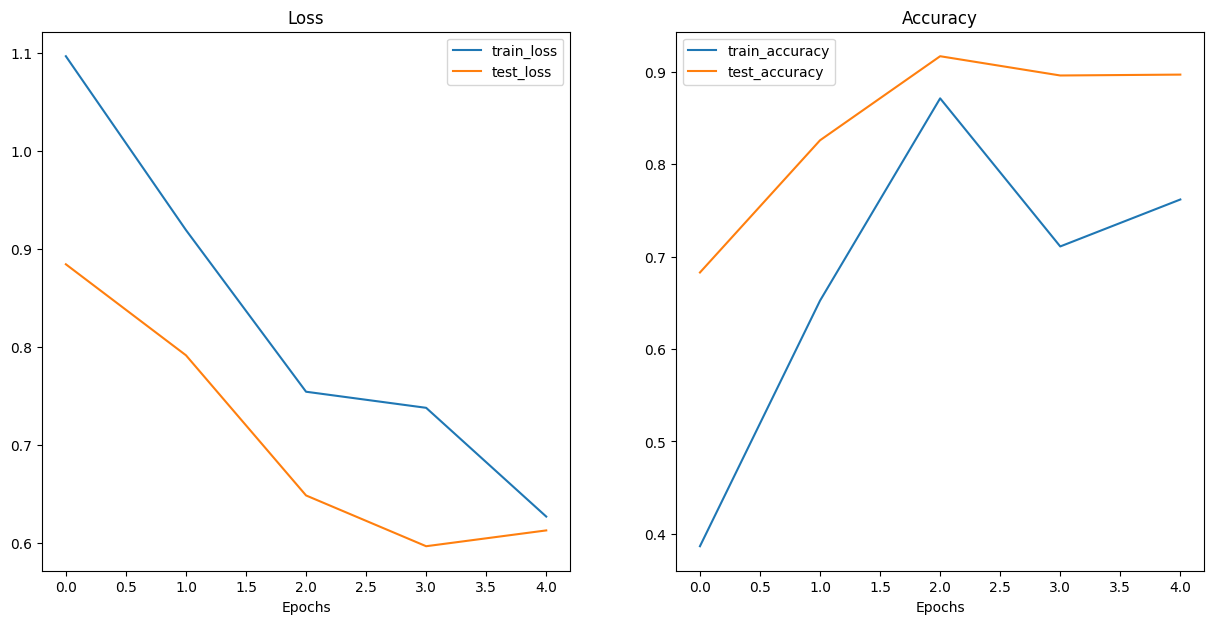

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] couldn't find helper_functions.py downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    request = requests.get(url)
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's adhere to the data explorers moto of *visualize, visualize, visualize*!

some things to keep in mind when making predictions/inference on test data/custom data

We have to make sure that our test/custom data is:
* the same shape - images need to be the same shape as model was trained on
* the same datatype - custom data should be in the same datatype
* the same device - custom data on the same device as the model
* the same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automatically lets create a function

1. Take in a trained model, a list of class names, a file path to a target image, an image size, a transform and a target device
2. Open the image `PIL.image.Open()`
3. Create a transform if one doesnt exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` to make sure its ready for inference
(this will turn things off like nn.Dropout())
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to the batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8

In [ ]:
from typing import List, Tuple
from PIL import Image

from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. create a transform if one doesnt exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model(also ensure its on the target device)
    target_image_pred = model(transformed_image.to(device))

    # 8. Convert the model's output logics to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. convert the model's pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. plot the image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


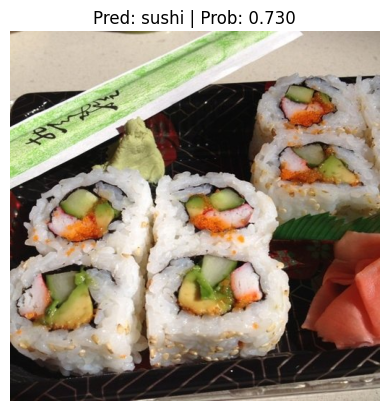

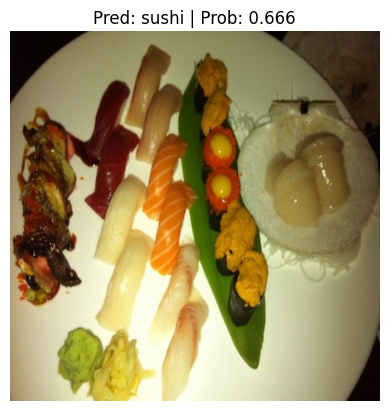

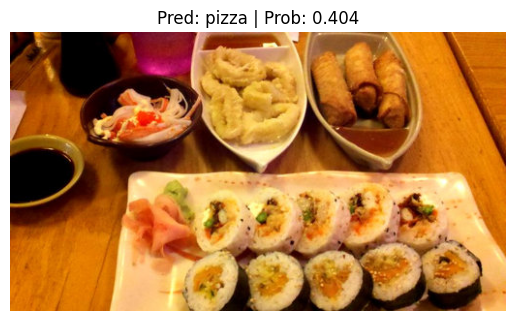

In [ ]:
# get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the image
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

In [ ]:
import requests

# setup custom image path
custom_image_path = data_path / "04-sushi-google.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    url = "https://asianinspirations.com.au/wp-content/uploads/2021/03/How-to-make-your-own-sushi-rolls_00-Feat-Img.jpg"
    request = requests.get(url)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists,  skipping download...")


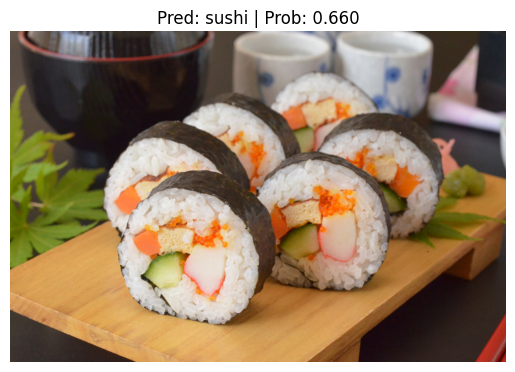

In [ ]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    image_size=(224, 224))

## Exercises and Extra curriculum

### 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.

In [ ]:
!pip install -q torchmetrics -U mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.9 MB/s eta 0:00:00


In [ ]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    # send the data to the correct device
    X, y = X.to(device), y.to(device)
    # do the forward pass
    y_logits = model(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
    # put the predictions on the cpu for evaluation
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

In [ ]:
y_pred_tensor

tensor([0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 2,
        2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1,
        0, 0, 2])

In [ ]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
test_pred_probs = []
model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

    test_pred_probs.append(pred_probs)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_pred_probs = torch.cat(test_pred_probs).cpu()
highest_probs, _ = torch.max(test_pred_probs, dim=1)


print(f"Predictions: {test_preds}")
print(f"Probilities: {highest_probs}")

  0%|          | 0/3 [00:00<?, ?it/s]

Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])
Probilities: tensor([0.8008, 0.6676, 0.6227, 0.6876, 0.5550, 0.5379, 0.6683, 0.6331, 0.7553,
        0.8344, 0.6605, 0.5472, 0.4744, 0.4383, 0.5590, 0.5507, 0.4284, 0.6058,
        0.7464, 0.7817, 0.6213, 0.5330, 0.6127, 0.7303, 0.4771, 0.6427, 0.6650,
        0.4171, 0.7399, 0.4062, 0.8074, 0.7750, 0.7382, 0.5650, 0.3887, 0.7293,
        0.8302, 0.5505, 0.3600, 0.7622, 0.7633, 0.7450, 0.6209, 0.4496, 0.4942,
        0.4105, 0.4726, 0.4866, 0.6346, 0.8593, 0.6075, 0.3872, 0.5267, 0.6424,
        0.6854, 0.4110, 0.6213, 0.7455, 0.3836, 0.6413, 0.4295, 0.7470, 0.4140,
        0.4835, 0.3645, 0.4828, 0.4102, 0.6285, 0.6639, 0.6075, 0.4133, 0.4834,
        0.4423, 0.3812, 0.6259])


In [ ]:
highest_probs, _ = torch.max(test_pred_probs, dim=1)
highest_probs


tensor([0.8008, 0.6676, 0.6227, 0.6876, 0.5550, 0.5379, 0.6683, 0.6331, 0.7553,
        0.8344, 0.6605, 0.5472, 0.4744, 0.4383, 0.5590, 0.5507, 0.4284, 0.6058,
        0.7464, 0.7817, 0.6213, 0.5330, 0.6127, 0.7303, 0.4771, 0.6427, 0.6650,
        0.4171, 0.7399, 0.4062, 0.8074, 0.7750, 0.7382, 0.5650, 0.3887, 0.7293,
        0.8302, 0.5505, 0.3600, 0.7622, 0.7633, 0.7450, 0.6209, 0.4496, 0.4942,
        0.4105, 0.4726, 0.4866, 0.6346, 0.8593, 0.6075, 0.3872, 0.5267, 0.6424,
        0.6854, 0.4110, 0.6213, 0.7455, 0.3836, 0.6413, 0.4295, 0.7470, 0.4140,
        0.4835, 0.3645, 0.4828, 0.4102, 0.6285, 0.6639, 0.6075, 0.4133, 0.4834,
        0.4423, 0.3812, 0.6259])

In [ ]:
test_pred_probs

tensor([[0.8008, 0.1059, 0.0932],
        [0.6676, 0.0772, 0.2552],
        [0.6227, 0.2610, 0.1163],
        [0.6876, 0.1594, 0.1529],
        [0.5550, 0.1830, 0.2620],
        [0.5379, 0.2603, 0.2018],
        [0.6683, 0.2077, 0.1239],
        [0.6331, 0.1287, 0.2382],
        [0.7553, 0.1009, 0.1439],
        [0.8344, 0.0579, 0.1077],
        [0.6605, 0.1813, 0.1581],
        [0.5472, 0.1773, 0.2756],
        [0.1960, 0.3295, 0.4744],
        [0.4123, 0.4383, 0.1494],
        [0.5590, 0.2123, 0.2287],
        [0.5507, 0.1188, 0.3305],
        [0.4284, 0.1698, 0.4019],
        [0.6058, 0.1904, 0.2038],
        [0.7464, 0.1385, 0.1151],
        [0.7817, 0.1137, 0.1046],
        [0.6213, 0.1404, 0.2384],
        [0.5330, 0.2670, 0.2000],
        [0.6127, 0.2376, 0.1497],
        [0.7303, 0.1345, 0.1353],
        [0.4771, 0.1706, 0.3523],
        [0.2345, 0.6427, 0.1228],
        [0.2233, 0.6650, 0.1117],
        [0.2416, 0.3412, 0.4171],
        [0.0998, 0.7399, 0.1603],
        [0.406

In [ ]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

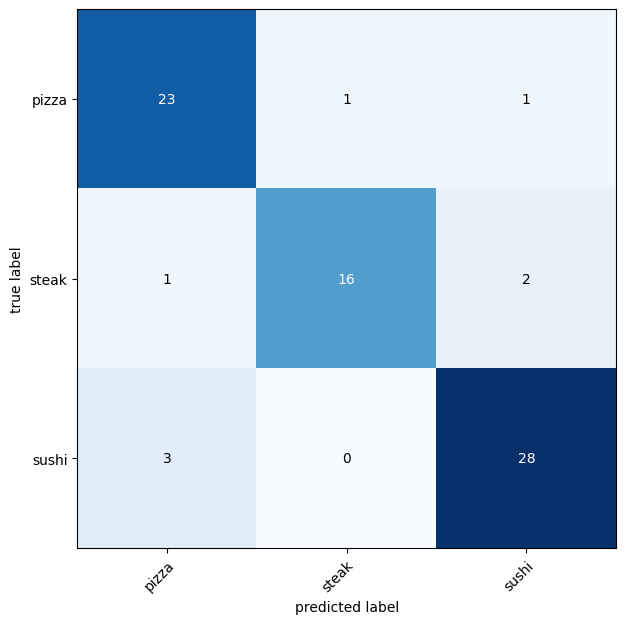

In [ ]:
# Setup confusion matrix instance
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

In [ ]:
from torchvision import datasets, transforms
train_data = datasets.ImageFolder(train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(test_dir, transform=auto_transforms)


## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
Predicting across all of the test dataset, storing the labels and predicted probabilities.
Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".
Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:

 - Create a DataFrame with sample, label, prediction, pred prob
 - Sort DataFrame by correct (does label == prediction)
 - Sort DataFrame by pred prob (descending)
 - Plot the top 5 "most wrong" image predictions

In [ ]:
test_data

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )

In [ ]:
import pandas as pd

In [ ]:
class_name_label = [class_names[target] for target in test_data.targets]
class_name_label

['pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi']

In [ ]:
class_name_pred_label = [class_names[pred] for pred in test_preds]
class_name_pred_label

['pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'sushi',
 'steak',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'pizza',
 'steak',
 'steak',
 'sushi',
 'steak',
 'pizza',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'sushi',
 'steak',
 'steak',
 'steak',
 'steak',
 'steak',
 'sushi',
 'sushi',
 'pizza',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'pizza',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'pizza',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi',
 'sushi']

In [ ]:
data = {"pred_label": test_preds,
        "probability": highest_probs,
        "pred_class": class_name_pred_label,
        "truth_label": test_truth,
        "truth_class": class_name_label}
df = pd.DataFrame(data=data)


In [ ]:
df["correct"] = df["pred_label"] == df["truth_label"]
df

,pred_label,probability,pred_class,truth_label,truth_class,correct
0,0,0.800824,pizza,0,pizza,True
1,0,0.667610,pizza,0,pizza,True
2,0,0.622698,pizza,0,pizza,True
3,0,0.687643,pizza,0,pizza,True
4,0,0.555031,pizza,0,pizza,True
...,...,...,...,...,...,...
70,2,0.413346,sushi,2,sushi,True
71,2,0.483415,sushi,2,sushi,True
72,2,0.442331,sushi,2,sushi,True
73,2,0.381207,sushi,2,sushi,True


In [ ]:
df["correct"].value_counts()

True     67
False     8
Name: correct, dtype: int64

In [ ]:
df.sort_values(by= ["correct"]).head()

,pred_label,probability,pred_class,truth_label,truth_class,correct
38,2,0.360041,sushi,1,steak,False
58,0,0.383587,pizza,2,sushi,False
46,0,0.472570,pizza,2,sushi,False
13,1,0.438315,steak,0,pizza,False
29,0,0.406230,pizza,1,steak,False


In [ ]:
df['correct']

0     True
1     True
2     True
3     True
4     True
      ... 
70    True
71    True
72    True
73    True
74    True
Name: correct, Length: 75, dtype: bool

In [ ]:
df.sort_values(by=["probability"])

,pred_label,probability,pred_class,truth_label,truth_class,correct
38,2,0.360041,sushi,1,steak,False
64,0,0.364522,pizza,2,sushi,False
73,2,0.381207,sushi,2,sushi,True
58,0,0.383587,pizza,2,sushi,False
51,2,0.387167,sushi,2,sushi,True
...,...,...,...,...,...,...
0,0,0.800824,pizza,0,pizza,True
30,1,0.807393,steak,1,steak,True
36,1,0.830220,steak,1,steak,True
9,0,0.834446,pizza,0,pizza,True


In [ ]:
df[df["correct"] == False]

,pred_label,probability,pred_class,truth_label,truth_class,correct
12,2,0.474437,sushi,0,pizza,False
13,1,0.438315,steak,0,pizza,False
27,2,0.417134,sushi,1,steak,False
29,0,0.406230,pizza,1,steak,False
38,2,0.360041,sushi,1,steak,False
46,0,0.472570,pizza,2,sushi,False
58,0,0.383587,pizza,2,sushi,False
64,0,0.364522,pizza,2,sushi,False


In [ ]:
top_5_most_wrong = df.sort_values(by=["correct", "probability"], ascending=[True, False]).head()
top_5_most_wrong

,pred_label,probability,pred_class,truth_label,truth_class,correct
12,2,0.474437,sushi,0,pizza,False
46,0,0.472570,pizza,2,sushi,False
13,1,0.438315,steak,0,pizza,False
27,2,0.417134,sushi,1,steak,False
29,0,0.406230,pizza,1,steak,False


### 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [ ]:
import requests

# setup custom image path
custom_image_path = data_path / "01-pizza-custom.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    url = "https://plus.unsplash.com/premium_photo-1672498294724-dde3b2e41e19?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    request = requests.get(url)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

In [ ]:
custom_image_path

PosixPath('data/01-pizza-custom.jpeg')

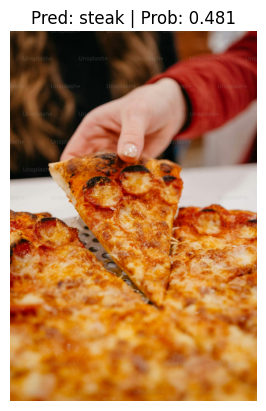

In [ ]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
import requests

# setup custom image path
custom_image_path = data_path / "01-cupcake-custom.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    url = "https://images.unsplash.com/photo-1563729784474-d77dbb933a9e?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    request = requests.get(url)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

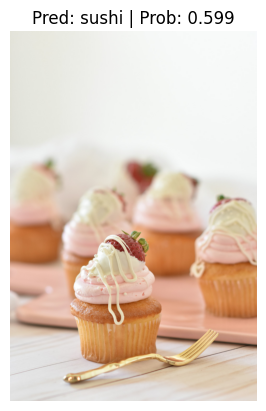

In [ ]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

### 4. Train the model from section 4 in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?
See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

- the model was struggling to learn more than what it already did, train loss, and test loss were fluctuating

In [ ]:
# import train function
from going_modular.going_modular import engine

# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer

start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()

print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5398 | train_acc: 0.9180 | test_loss: 0.5514 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.5155 | train_acc: 0.9297 | test_loss: 0.5343 | test_acc: 0.8665
Epoch: 3 | train_loss: 0.4519 | train_acc: 0.9258 | test_loss: 0.4896 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.4659 | train_acc: 0.9258 | test_loss: 0.4618 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.4170 | train_acc: 0.9570 | test_loss: 0.4903 | test_acc: 0.8258
Epoch: 6 | train_loss: 0.4506 | train_acc: 0.8203 | test_loss: 0.4523 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.4573 | train_acc: 0.8125 | test_loss: 0.4964 | test_acc: 0.8665
Epoch: 8 | train_loss: 0.4072 | train_acc: 0.8242 | test_loss: 0.4231 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.3821 | train_acc: 0.9297 | test_loss: 0.4261 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4910 | train_acc: 0.7891 | test_loss: 0.4621 | test_acc: 0.8665
[INFO] Total training time: 367.095 seconds


### 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
You can find the 20% Pizza, Steak, Sushi dataset on the course GitHub. It was created with the notebook extras/04_custom_data_creation.ipynb.

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# setup path for data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists...")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / image_data_zip_path, "wb") as f:
    url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
    request = requests.get(url)
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)


os.remove(data_path / image_data_zip_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                              test_dir=test_dir,
                              transform=auto_transforms,
                              batch_size=32,
                              num_workers=os.cpu_count())

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7edc8c3f3340>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# import train function
from going_modular.going_modular import engine

# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# end the timer and print how long it took
end_time = timer()

print(f"[INFO] the total time to train {end_time - start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4423 | train_acc: 0.8771 | test_loss: 0.3822 | test_acc: 0.8795
Epoch: 2 | train_loss: 0.3966 | train_acc: 0.8667 | test_loss: 0.3451 | test_acc: 0.9102
Epoch: 3 | train_loss: 0.3630 | train_acc: 0.9000 | test_loss: 0.3035 | test_acc: 0.9165
Epoch: 4 | train_loss: 0.3215 | train_acc: 0.9062 | test_loss: 0.2996 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.3880 | train_acc: 0.8479 | test_loss: 0.3093 | test_acc: 0.8886
[INFO] the total time to train 360.039 seconds


In [ ]:
import requests

# setup custom image path
custom_image_path = data_path / "01-pizza-custom.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    url = "https://plus.unsplash.com/premium_photo-1672498294724-dde3b2e41e19?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
    request = requests.get(url)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

data/01-pizza-custom.jpeg already exists, skipping download...


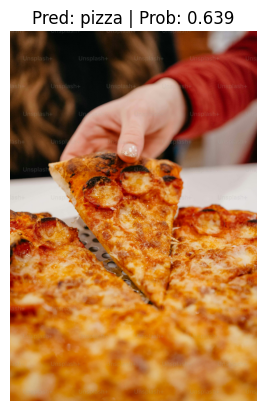

In [ ]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

### 6. Try a different model from torchvision.models on the Pizza, Steak, Sushi data, how does this model perform?
You'll have to change the size of the classifier layer to suit our problem.
You may want to try an EfficientNet with a higher number than our B0, perhaps torchvision.models.efficientnet_b2()?
Note: Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
import torchvision

weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT

In [ ]:
auto_transforms = weights.transforms()

In [ ]:
model_0 = torchvision.models.efficientnet_b3(weights=weights)
model_0

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 69.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
model_0.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1)

In [ ]:
model_0.avgpool

AdaptiveAvgPool2d(output_size=1)

In [ ]:
model_0.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

In [ ]:
from torchinfo import summary

summary(model=model_0,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1536, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 40, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 40, 112, 112]    1,080                True
│    │    └─BatchNorm2d (1)                                  [1, 40, 112, 112]    [1, 40, 112, 112]    80                   True
│    │    └─SiLU (2)                                         [1, 40, 112, 112]    [1, 40, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 40, 112, 112]    [1, 24, 112,

In [ ]:

for param in model_0.features.parameters():
  # print(param)
  param.requires_grad = False # this freezes all of our features

In [ ]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536,
              out_features=len(class_names)).to(device)
)

In [ ]:
summary(model=model_0,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1536, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 40, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 40, 112, 112]    (1,080)              False
│    │    └─BatchNorm2d (1)                                  [1, 40, 112, 112]    [1, 40, 112, 112]    (80)                 False
│    │    └─SiLU (2)                                         [1, 40, 112, 112]    [1, 40, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 40, 112, 112]    [1, 2

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

In [ ]:
from going_modular.going_modular import engine
from timeit import default_timer as Timer

# start the timer
start_time = timer()

results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# end the timer
end_time = timer()

print(f"[INFO] Total time to train {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32,
                                                                               num_workers=os.cpu_count())

In [ ]:
from going_modular.going_modular import engine
from timeit import default_timer as Timer

# set the seeds
torch.manual_seed(42)

# start the timer
start_time = timer()

results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# end the timer
end_time = timer()

print(f"[INFO] Total time to train {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9251 | train_acc: 0.6146 | test_loss: 0.7282 | test_acc: 0.9597
Epoch: 2 | train_loss: 0.6789 | train_acc: 0.8667 | test_loss: 0.5577 | test_acc: 0.9597
Epoch: 3 | train_loss: 0.5419 | train_acc: 0.8896 | test_loss: 0.4703 | test_acc: 0.9659
Epoch: 4 | train_loss: 0.5037 | train_acc: 0.8562 | test_loss: 0.4023 | test_acc: 0.9659
Epoch: 5 | train_loss: 0.4229 | train_acc: 0.8958 | test_loss: 0.3812 | test_acc: 0.9568
[INFO] Total time to train 1412.828 seconds


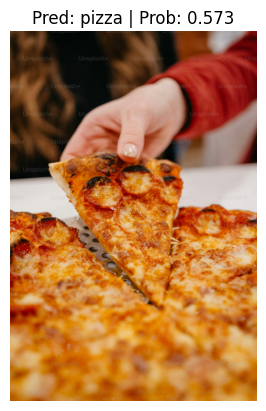

In [ ]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names)